In [2]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import classification_report
from keras.applications import VGG19
from imutils import paths
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle

In [3]:
LABELS = set(["Crown and Root Rot", "Healthy Wheat", "Leaf Rust", "Wheat Loose Smut","Septoria"])
imagePaths = list(paths.list_images(r"C:\Users\AMEY\Downloads\Training Set(Wheat Disease)"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
# extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
# if the label of the current image is not part of the labels
 # are interested in, then ignore the image
    if label not in LABELS:
        continue
# load the image, convert it to RGB channel ordering, and resize
 # it to be a fixed 224x224 pixels, ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
# update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [4]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
 test_size=0.25, stratify=labels, random_state=42)

In [5]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
 rotation_range=30,
 zoom_range=0.15,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.15,
 horizontal_flip=True,
 fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [6]:
# load the VGG19 network, ensuring the head FC layer sets are left
# off
headmodel = VGG19(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
model = headmodel.output
model = AveragePooling2D(pool_size=(5, 5))(model)
model = Flatten(name="flatten")(model)
model = Dense(512, activation="relu")(model)
model = Dropout(0.4)(model)
model = Dense(len(lb.classes_), activation="softmax")(model)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
moodel = Model(inputs=headmodel.input, outputs=model)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in headmodel.layers:
    layer.trainable = False

In [6]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
opt = Adam(learning_rate=1e-3)
moodel.compile(loss="categorical_crossentropy", optimizer=opt,
               metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
H = moodel.fit(
    trainAug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX) // 64,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 64,
    epochs=25)

Epoch 1/25
66/66 [==============================] - 410s 6s/step - loss: 1.8584 - accuracy: 0.6257 - val_loss: 0.4914 - val_accuracy: 0.8395
Epoch 2/25
66/66 [==============================] - 436s 7s/step - loss: 0.7047 - accuracy: 0.7756 - val_loss: 0.3835 - val_accuracy: 0.8764
Epoch 3/25
66/66 [==============================] - 437s 7s/step - loss: 0.5345 - accuracy: 0.8176 - val_loss: 0.2997 - val_accuracy: 0.8977
Epoch 4/25
66/66 [==============================] - 438s 7s/step - loss: 0.4633 - accuracy: 0.8448 - val_loss: 0.3263 - val_accuracy: 0.9062
Epoch 5/25
66/66 [==============================] - 441s 7s/step - loss: 0.4383 - accuracy: 0.8491 - val_loss: 0.3007 - val_accuracy: 0.8991
Epoch 6/25
66/66 [==============================] - 435s 7s/step - loss: 0.3874 - accuracy: 0.8624 - val_loss: 0.2894 - val_accuracy: 0.9020
Epoch 7/25
66/66 [==============================] - 425s 6s/step - loss: 0.3836 - accuracy: 0.8665 - val_loss: 0.2489 - val_accuracy: 0.9233
Epoch 8/25
66

23/23 [==============================] - 126s 5s/step
                    precision    recall  f1-score   support

Crown and Root Rot       0.97      0.94      0.95       128
     Healthy Wheat       0.93      0.96      0.94       593
         Leaf Rust       0.96      0.91      0.93       233
          Septoria       0.95      0.94      0.95       286
  Wheat Loose Smut       0.92      0.91      0.91       180

          accuracy                           0.94      1420
         macro avg       0.94      0.93      0.94      1420
      weighted avg       0.94      0.94      0.94      1420



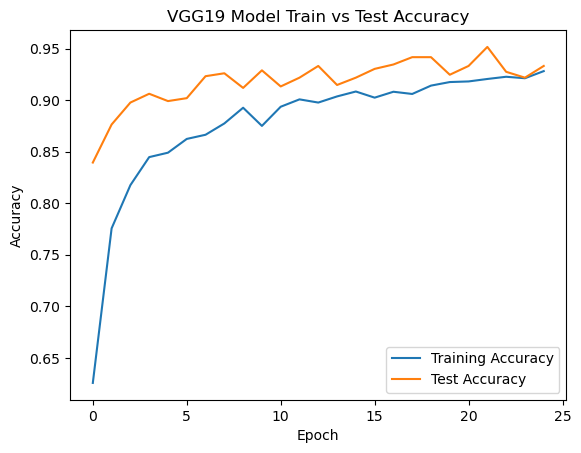

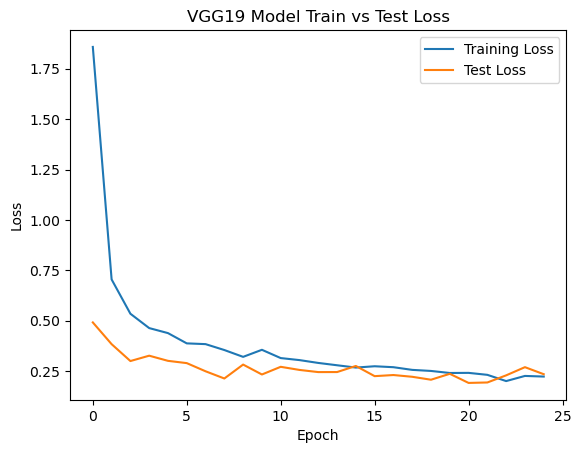

In [8]:
# evaluate the network
predictions = moodel.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=lb.classes_))
# plot the training loss and accuracy
N = 25
plt.plot(np.arange(0, N), H.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), H.history['val_accuracy'], label="Test Accuracy")
plt.title('VGG19 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.plot(H.history['loss'], label="Training Loss")
plt.plot(H.history['val_loss'], label="Test Loss")
plt.title('VGG19 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [9]:
#Save the Model and label file to Disk
moodel.save(r"C:\Users\AMEY\OneDrive\डेस्कटॉप\Sem 4 project\wheatmodel1.h5")
f = open("label", "wb")
f.write(pickle.dumps(lb))
f.close()

C:\Users\AMEY\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
from keras.models import load_model
import numpy as np
import imutils
import cv2
from keras.models import load_model
from collections import deque
import pickle

# construct the argument parse and parse the arguments
model_path =r"C:\Users\AMEY\OneDrive\डेस्कटॉप\Sem 4 project\wheatmodel.h5"
input = r"C:\Users\AMEY\OneDrive\डेस्कटॉप\Sem 4 project\input image1.jfif"
label = r"C:\Users\AMEY\OneDrive\डेस्कटॉप\Sem 4 project\label"

moodel = load_model(model_path)
lb = pickle.loads(open("label", "rb").read())

mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)

vs = cv2.VideoCapture(input)

(W, H) = (None, None)

while True:
    (grabbed, frame) = vs.read()

    if not grabbed:
        break

    if W is None or H is None:
        (H, W) = frame.shape[:2]

    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean

    preds = moodel.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)

    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = lb.classes_[i]

    text = "PREDICTION: {}".format(label.upper())
    cv2.putText(output, text, (4, 4), cv2.FONT_HERSHEY_PLAIN,
        0.25, (200,255,155), 2)

    cv2.imshow("Output",output)
    key = cv2.waitKey(10) & 0xFF

    if key == ord("q"):
        break

vs.release()

1/1 [==============================] - 0s 203ms/step


In [ ]:
import numpy as np
import cv2
from keras.models import load_model
from collections import deque
import pickle

# Load the model
model_path = r"C:\Users\AMEY\OneDrive\डेस्कटॉप\Sem 4 project\wheatmodel.h5"
model = load_model(model_path)

# Load the label binarizer
label_path = r"C:\Users\AMEY\OneDrive\डेस्कटॉप\Sem 4 project\label"
with open(label_path, "rb") as f:
    lb = pickle.load(f)

# Constants
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=128)

# Input image path
input_path = r"C:\Users\AMEY\Downloads\test.jpg"  # Replace with your image path

# Read the image
frame = cv2.imread(input_path)

output = frame.copy()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = cv2.resize(frame, (224, 224)).astype("float32")
frame -= mean

preds = model.predict(np.expand_dims(frame, axis=0))[0]
Q.append(preds)

results = np.array(Q).mean(axis=0)
i = np.argmax(results)
label = lb.classes_[i]

text = "Preiction: {}".format(label.upper())
cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

cv2.imshow("Output", output)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_probs = moodel.predict(testX)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
for i in range(len(lb.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {} (area = {:.2f})'.format(lb.classes_[i], roc_auc[i]))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [7]:
moodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     